In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Set random seed for reproducibility
np.random.seed(42)

def generate_data(n_rows=1000):
    data = []

    for i in range(n_rows):
        # Existing variable calculations (temperature, humidity, etc.)
        day_of_year = i % 365
        base_temp = 15 + 10 * np.sin(2 * np.pi * day_of_year / 365)
        temp = np.clip(base_temp + np.random.normal(0, 3), 10, 40)
        humidity = np.clip(70 - 0.8 * (temp - 20) + np.random.normal(0, 5), 30, 95)
        rainfall_chance = 0.2 + 0.3 * np.sin(2 * np.pi * (day_of_year - 90) / 365)
        rainfall = min(np.random.exponential(2), 30) if np.random.random() < rainfall_chance else 0
        soil_moisture = np.clip(40 + 0.8 * (humidity - 60) + 2 * rainfall + np.random.normal(0, 5), 15, 80)
        gwi = 0.7 + 0.0005 * i + 0.05 * np.sin(2 * np.pi * day_of_year / 365)
        crop_water = np.clip(15 + 0.5 * (temp - 20) - 0.2 * (humidity - 60) + np.random.normal(0, 2), 5, 35)
        irrigation_need = max(0, crop_water - (0.3 * soil_moisture + 0.5 * rainfall))

        # Modified water control logic for 50% balance
        #water_control = 1 if (soil_moisture < 45 or irrigation_need > 10) else 0
        water_control = 1 if (soil_moisture < 45 + np.random.normal(0,5)) else 0
        data.append([
            round(soil_moisture, 1), round(temp, 1), round(humidity, 1),
            round(rainfall, 1), round(gwi, 2), round(crop_water, 1),
            round(irrigation_need, 1), water_control
        ])

    df = pd.DataFrame(data, columns=[
        "Soil_Moisture(%)", "Temperature(¬∞C)", "Humidity(%)",
        "Rainfall(mm)", "Global_Warming_Index", "Crop_Water_Needs(liters)",
        "Irrigation_Need(liters)", "Water_Control"
    ])

    # Force 50/50 balance if needed
    current_ones = df['Water_Control'].sum()
    if current_ones < n_rows//2:
        # Find rows closest to threshold and flip them
        df['score'] = (45 - df['Soil_Moisture(%)']) + (df['Irrigation_Need(liters)'] - 10)
        flip_candidates = df[df['Water_Control'] == 0].nlargest(n_rows//2 - current_ones, 'score')
        df.loc[flip_candidates.index, 'Water_Control'] = 1
        df = df.drop(columns=['score'])

    return df

# Call the function to create the dataset
df = generate_data()  # This line was missing
# Generate and save

df.to_csv("balanced_irrigation_dataset.csv", index=False)
print("Dataset saved successfully!")

Dataset saved successfully!


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Basic statistics
print(df.describe())

       Soil_Moisture(%)  Temperature(¬∞C)  Humidity(%)  Rainfall(mm)  \
count       1000.000000       1000.00000  1000.000000   1000.000000   
mean          51.335400         16.71530    72.587300      0.516000   
std            7.775558          6.10831     6.817482      1.319547   
min           31.100000         10.00000    50.100000      0.000000   
25%           45.800000         10.00000    67.800000      0.000000   
50%           51.200000         16.25000    72.900000      0.000000   
75%           56.500000         22.00000    77.300000      0.100000   
max           79.000000         32.80000    92.100000     11.700000   

       Global_Warming_Index  Crop_Water_Needs(liters)  \
count           1000.000000               1000.000000   
mean               0.952740                 11.021200   
std                0.143646                  4.332681   
min                0.700000                  5.000000   
25%                0.800000                  7.300000   
50%              

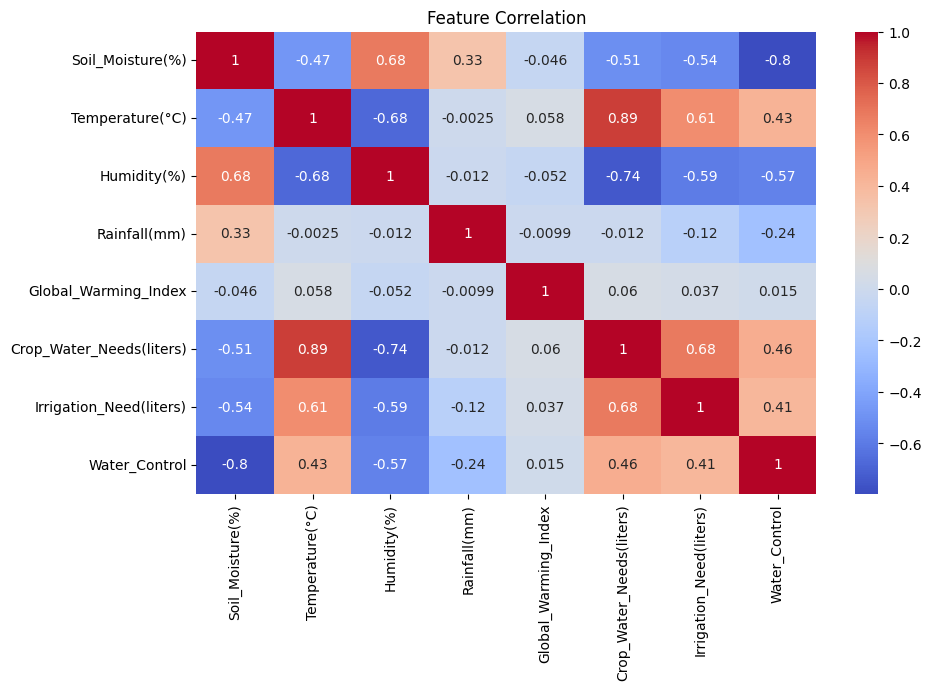

In [4]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation")
plt.show()


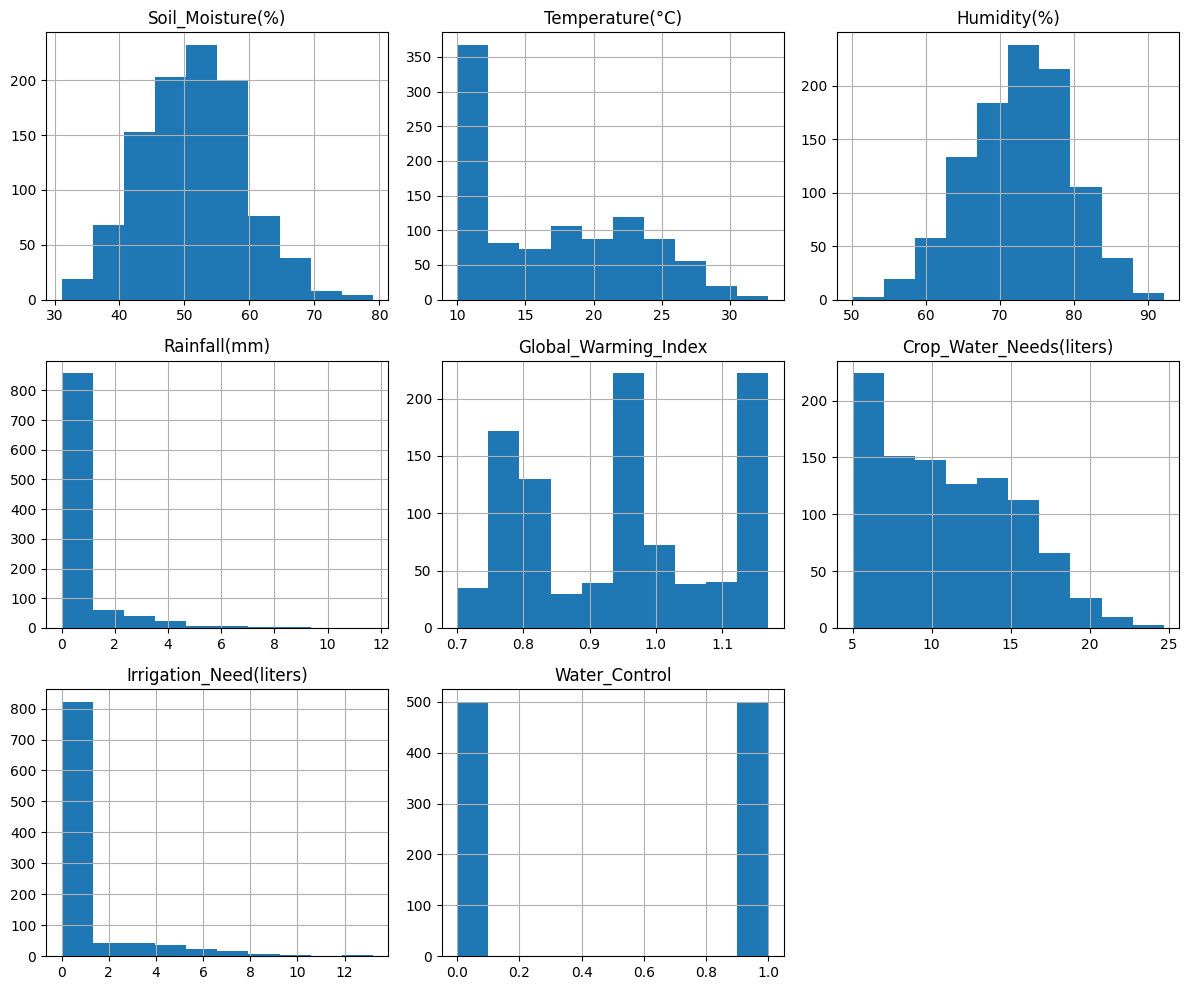

In [5]:
# Distribution of key features
df.hist(figsize=(12, 10))
plt.tight_layout()
plt.show()

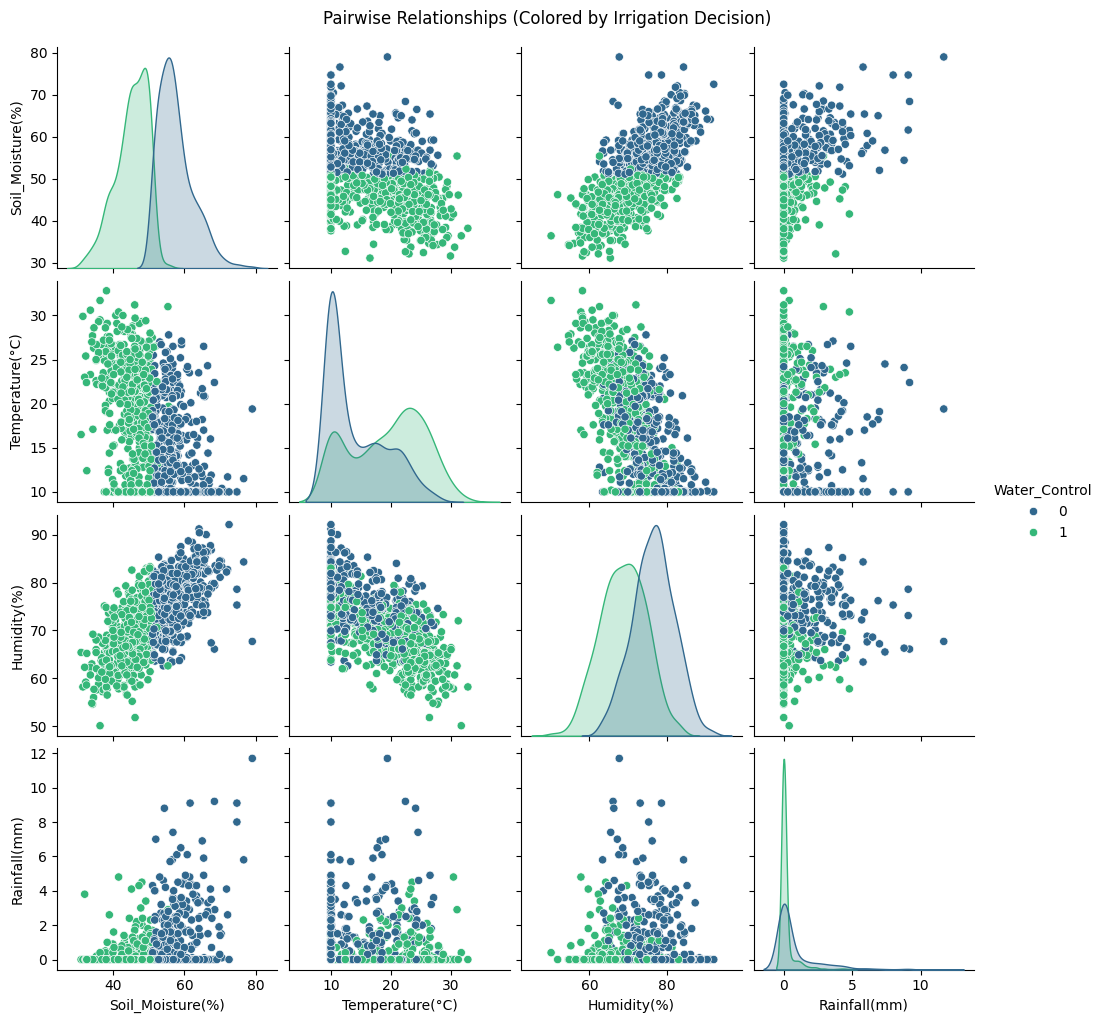

In [6]:
# Select key features to avoid overcrowding
features_to_plot = ['Soil_Moisture(%)', 'Temperature(¬∞C)', 'Humidity(%)', 'Rainfall(mm)', 'Water_Control']

# Create pairplot (may take a few seconds)
sns.pairplot(df[features_to_plot], hue='Water_Control', palette='viridis')
plt.suptitle("Pairwise Relationships (Colored by Irrigation Decision)", y=1.02)
plt.show()

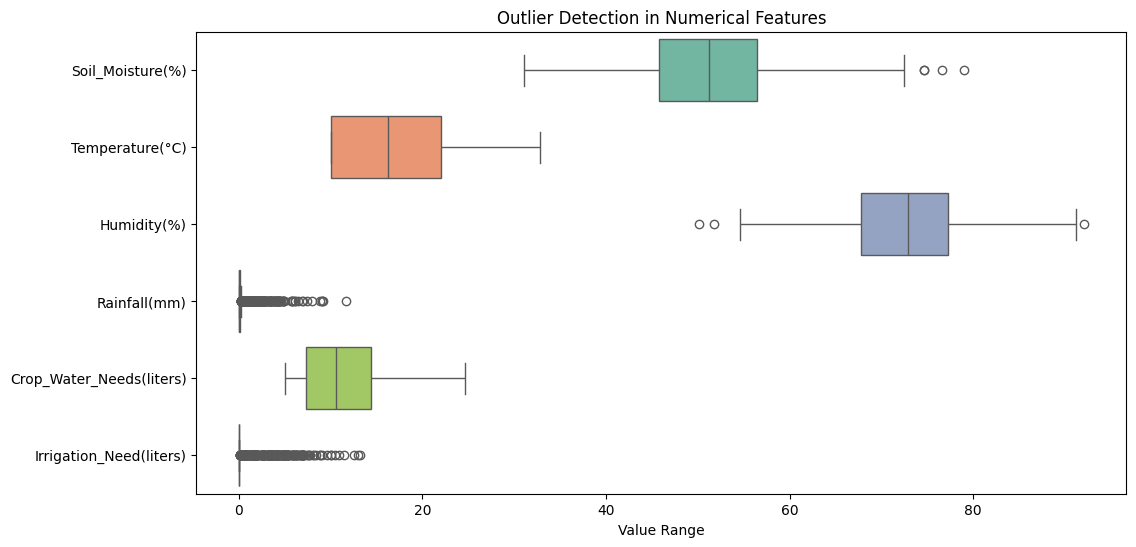

In [7]:
# Select numerical columns (excluding binary 'Water_Control')
num_cols = ['Soil_Moisture(%)', 'Temperature(¬∞C)', 'Humidity(%)',
            'Rainfall(mm)', 'Crop_Water_Needs(liters)', 'Irrigation_Need(liters)']

# Create boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[num_cols], orient='h', palette='Set2')
plt.title("Outlier Detection in Numerical Features")
plt.xlabel("Value Range")
plt.show()

In [8]:
df['Date'] = pd.date_range(start='2023-01-01', periods=len(df), freq='D')  # Daily data
df.set_index('Date', inplace=True)

/tmp/ipython-input-9-2926582366.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df['Temperature(¬∞C)'].resample('M').mean().plot(label='Avg Temp', color='red')
/tmp/ipython-input-9-2926582366.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df['Rainfall(mm)'].resample('M').sum().plot(label='Total Rainfall', color='blue', secondary_y=True)


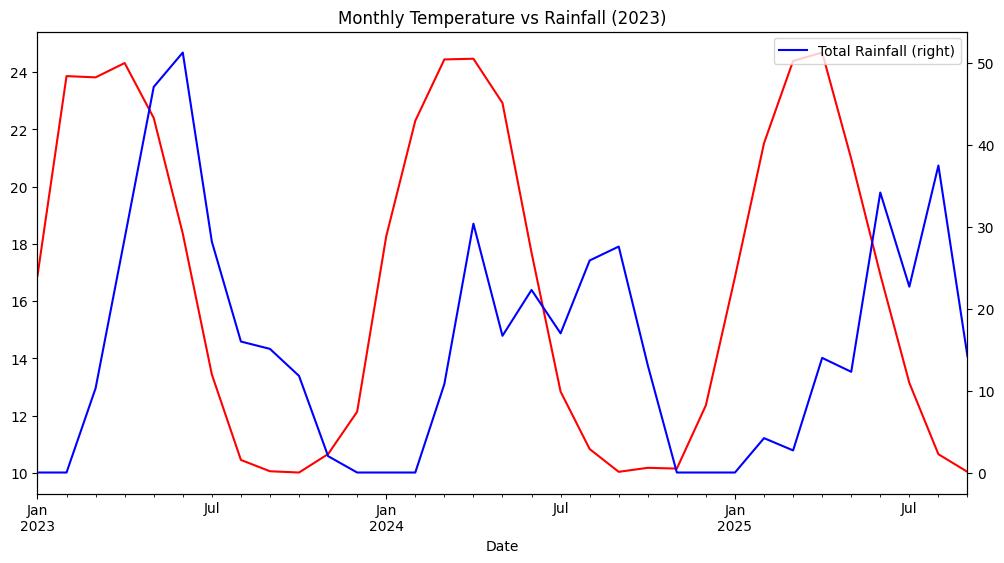

In [9]:
# Resample by month and plot key metrics
plt.figure(figsize=(12, 6))
df['Temperature(¬∞C)'].resample('M').mean().plot(label='Avg Temp', color='red')
df['Rainfall(mm)'].resample('M').sum().plot(label='Total Rainfall', color='blue', secondary_y=True)
plt.title("Monthly Temperature vs Rainfall (2023)")
plt.xlabel("Date")
plt.legend()
plt.show()

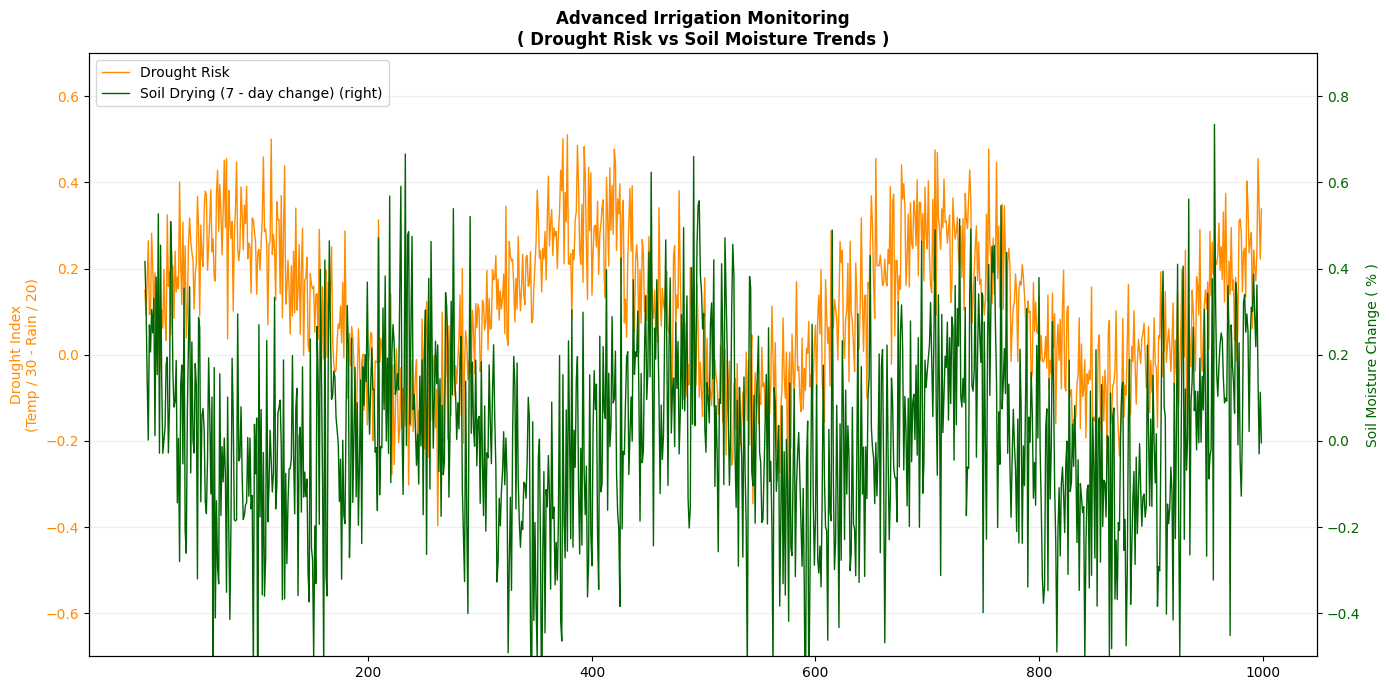

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Generate dummy data that resembles the provided chart
np.random.seed(42)
index = np.arange(1000)
drought_risk = 0.2 * np.sin(index / 50) + 0.1 * np.random.randn(1000) + 0.1
soil_drying = 0.15 * np.sin(index / 40 + 2) + 0.2 * np.random.randn(1000)

# Create a Pandas DataFrame
df = pd.DataFrame({'Drought_Index': drought_risk, 'Soil_Trend': soil_drying}, index=index)

plt.figure(figsize=(14, 7))

# PRIMARY PLOT
ax = df['Drought_Index'].plot(
    color='darkorange',
    linewidth=1,
    label='Drought Risk'
)
ax.set_ylabel('Drought Index\n(Temp / 30 - Rain / 20)', color='darkorange')
ax.tick_params(axis='y', labelcolor='darkorange')
ax.set_ylim(-0.7, 0.7)

# SECONDARY PLOT
ax2 = ax.twinx()  # Create a twin Axes sharing the x-axis
ax2.plot(df.index, df['Soil_Trend'], color='darkgreen', linewidth=1, label='Soil Drying (7 - day change) (right)')
ax2.set_ylabel('Soil Moisture Change ( % )', color='darkgreen')
ax2.tick_params(axis='y', labelcolor='darkgreen')
ax2.set_ylim(-0.5, 0.9)

# X-AXIS FORMATTING (simplified as there are no dates)
ax.set_xlabel('') # No specific x-axis labels in the example
ax.set_xticks([200, 400, 600, 800, 1000]) # Set explicit x-ticks

# TITLE AND GRID
plt.title('Advanced Irrigation Monitoring\n( Drought Risk vs Soil Moisture Trends )', fontweight='bold')
plt.grid(alpha=0.2)

# COMBINE LEGENDS
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.tight_layout()
plt.show()

In [11]:
features = [
    'Soil_Moisture(%)',
    'Temperature(¬∞C)',
    'Humidity(%)',
    'Rainfall(mm)',
    'Global_Warming_Index',
    'Crop_Water_Needs(liters)'
]

In [12]:
target = 'Water_Control'  # Binary (0 = Pump OFF, 1 = Pump ON)

In [13]:
import pandas as pd

# Load your dataset
df = pd.read_csv("balanced_irrigation_dataset.csv")

# Separate features (X) and target (y)
X = df[features]  # Input data
y = df[target]    # Output to predict

In [14]:
from sklearn.model_selection import train_test_split

# First split: Separate out TEST set (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Second split: Create TRAIN (64%) and VALIDATION (16%) from remaining
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.2,  # 0.2 * 0.8 = 0.16 (16% of original)
    random_state=42,
    stratify=y_temp
)

print(f"Train: {len(X_train)} samples")
print(f"Validation: {len(X_val)} samples")
print(f"Test: {len(X_test)} samples")

Train: 640 samples
Validation: 160 samples
Test: 200 samples


In [15]:
from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

# Fit ONLY on training data (important!)
X_train_scaled = scaler.fit_transform(X_train)

# Transform validation and test data using training stats
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)  # Don't touch until final evaluation

print("Data scaling complete!")

Data scaling complete!


In [16]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)

LogisticRegression(random_state=42)

In [17]:
from sklearn.metrics import accuracy_score, classification_report

# Predict on validation set
y_val_pred = model.predict(X_val_scaled)

# 1. Basic Accuracy
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred):.2%}")

# 2. Detailed Classification Report
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))


Validation Accuracy: 96.88%

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97        80
           1       0.96      0.97      0.97        80

    accuracy                           0.97       160
   macro avg       0.97      0.97      0.97       160
weighted avg       0.97      0.97      0.97       160



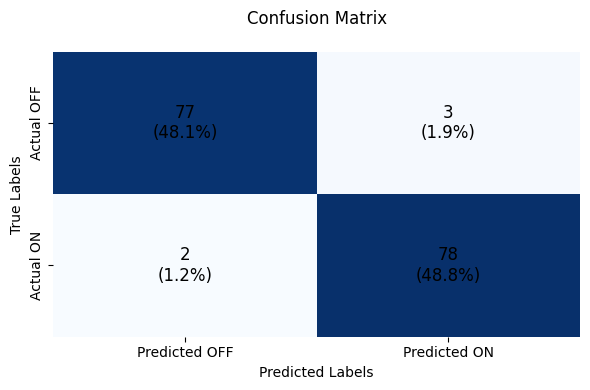

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Create confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Plot
plt.figure(figsize=(6, 4))
ax = sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                 xticklabels=['Predicted OFF', 'Predicted ON'],
                 yticklabels=['Actual OFF', 'Actual ON'],
                 cbar=False)

# Add custom annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        percent = count / cm.sum() * 100
        ax.text(j + 0.5, i + 0.5, f"{count}\n({percent:.1f}%)",
                ha='center', va='center', fontsize=12, color='black')

plt.title('Confusion Matrix', pad=20)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()


Confusion Matrix on Test Set:
[[96  4]
 [ 7 93]]


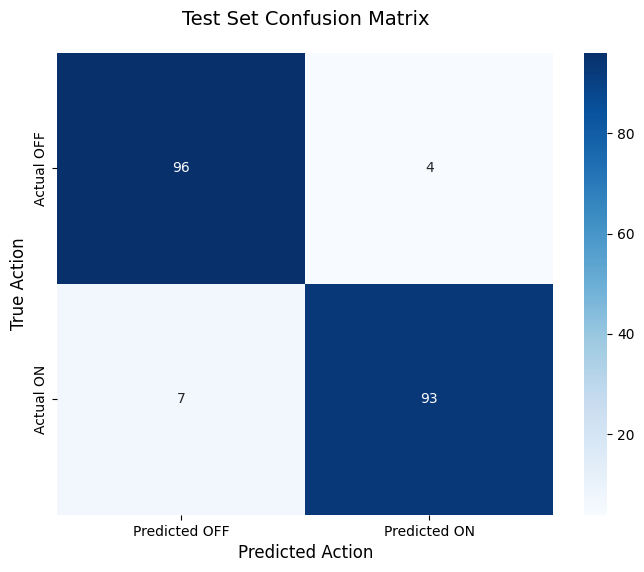


Test Set Accuracy: 0.9450
Test Set Precision (for 'ON'): 0.9588
Test Set Recall (for 'ON'): 0.9300
Test Set F1-Score (for 'ON'): 0.9442


In [19]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have:
# - model: Your trained machine learning model
# - X_test_scaled: Your scaled test features
# - y_test: Your true test labels

# 1. Make predictions on the test set
y_test_pred = model.predict(X_test_scaled)

# 2. Evaluate the predictions

# Confusion Matrix
cm_test = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix on Test Set:")
print(cm_test)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted OFF', 'Predicted ON'],
            yticklabels=['Actual OFF', 'Actual ON'])
plt.title('Test Set Confusion Matrix', fontsize=14, pad=20)
plt.xlabel('Predicted Action', fontsize=12)
plt.ylabel('True Action', fontsize=12)
plt.show()

# Calculate other metrics
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print(f"\nTest Set Accuracy: {accuracy:.4f}")
print(f"Test Set Precision (for 'ON'): {precision:.4f}")
print(f"Test Set Recall (for 'ON'): {recall:.4f}")
print(f"Test Set F1-Score (for 'ON'): {f1:.4f}")

In [20]:
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import numpy as np
from datetime import datetime
import pandas as pd
import time

# Create styled widgets
sensor_input = widgets.Textarea(
    placeholder='Paste Wokwi data here (e.g., 25.00,30.50,45.00,0.00)',
    layout=widgets.Layout(width='90%', height='60px'),
    style={'description_width': 'initial'}
)

process_btn = widgets.Button(
    description="üöÄ Process Data",
    button_style='success',
    layout=widgets.Layout(width='200px', height='40px')
)

output_area = widgets.Output()


# Create status display widget (initial waiting state)
status_display = widgets.HTML(
    value="""
    <div style='
        padding:15px;
        border-radius:5px;
        background:#ffffff;
        border:1px solid #e0e0e0;
        color:#34495e;
    '>
        <h3 style='margin-top:0; color:#2c3e50;'>üîç Process Data</h3>
        <p>Waiting for data...</p>
    </div>
    """,
    layout=widgets.Layout(width='90%', margin='10px 0')
)

# Create command display widget (initial state)
command_display = widgets.HTML(
    value="""
    <div style='
        padding:15px;
        border-radius:5px;
        background:#f8f9fa;
        border:1px solid #e0e0e0;
        color:#34495e;
        text-align:center;
    '>
        <p>Command will appear here</p>
    </div>
    """,
    layout=widgets.Layout(width='90%', margin='10px 0')
)

def process_data(_):
    with output_area:
        output_area.clear_output()
        try:
            # Get and validate input
            data = sensor_input.value.strip()
            if not all(part.replace('.','',1).isdigit() for part in data.split(',')):
                status_display.value = """
                <div style='padding:10px; border-radius:5px; background:#fff3cd; color:#856404;'>
                    ‚ö†Ô∏è Invalid format! Please use: SM,Temp,Humidity,Rainfall (e.g., 25.00,30.50,45.00,0.00)
                </div>
                """
                return

            # Process data
            sm, temp, hum, rain = map(float, data.split(','))
            gwi = 0.7 + 0.05 * np.sin(2 * np.pi * (datetime.now().timetuple().tm_yday) / 365)
            crop_water = np.clip(15 + 0.5*(temp - 20) - 0.2*(hum - 60) + np.random.normal(0, 2), 5, 35)

            sensor_df = pd.DataFrame([{
                'Soil_Moisture(%)': sm,
                'Temperature(¬∞C)': temp,
                'Humidity(%)': hum,
                'Rainfall(mm)': rain,
                'Global_Warming_Index': gwi,
                'Crop_Water_Needs(liters)': crop_water
            }], columns=features)

            sensor_scaled = scaler.transform(sensor_df)
            prediction = model.predict(sensor_scaled)
            proba = model.predict_proba(sensor_scaled)

            # Determine colors and icons
            if prediction[0] == 1:
                action_color = "#28a745"
                action_icon = "üö∞"
                action_text = "PUMP ON"
            else:
                action_color = "#dc3545"
                action_icon = "‚õî"
                action_text = "PUMP OFF"

            # Updated status display (ONLY THIS SECTION CHANGED)
            status_display.value = f"""
            <div style='padding:15px; border-radius:5px; background:#ffffff; border:1px solid #e0e0e0;'>
                <h3 style='margin-top:0; color:#2c3e50;'>üîç Prediction Results</h3>
                <div style='display:flex; justify-content:space-between; flex-wrap:wrap;'>
                    <div style='flex:1; min-width:200px; margin:5px; color:#34495e;'>
                        <h4 style='margin-bottom:5px; color:#2c3e50;'>üìä Sensor Data</h4>
                        <ul style='margin-top:0; padding-left:20px;'>
                            <li style='margin-bottom:5px;'>Soil Moisture: <strong>{sm}%</strong></li>
                            <li style='margin-bottom:5px;'>Temperature: <strong>{temp}¬∞C</strong></li>
                            <li style='margin-bottom:5px;'>Humidity: <strong>{hum}%</strong></li>
                            <li style='margin-bottom:5px;'>Rainfall: <strong>{rain}mm</strong></li>
                        </ul>
                    </div>
                    <div style='flex:1; min-width:200px; margin:5px; color:#34495e;'>
                        <h4 style='margin-bottom:5px; color:#2c3e50;'>üìà Model Output</h4>
                        <ul style='margin-top:0; padding-left:20px;'>
                            <li style='margin-bottom:5px;'>Prediction: <span style='color:{action_color}; font-weight:bold;'>{action_icon} {action_text}</span></li>
                            <li style='margin-bottom:5px;'>ON Confidence: <strong>{proba[0][1]*100:.1f}%</strong></li>
                            <li style='margin-bottom:5px;'>OFF Confidence: <strong>{proba[0][0]*100:.1f}%</strong></li>
                            <li style='margin-bottom:5px;'>GWI: <strong>{gwi:.2f}</strong></li>
                            <li style='margin-bottom:5px;'>Water Needs: <strong>{crop_water:.1f}L</strong></li>
                        </ul>
                    </div>
                </div>
            </div>
            """

            # Update command display with prominent styling (unchanged)
            command_display.value = f"""
            <div style='padding:20px; border-radius:8px; background:{action_color}; color:white; text-align:center;'>
                <h3 style='margin-top:0; color:white;'>üì≤ WOKWI COMMAND</h3>
                <div style='font-size:32px; font-weight:bold; letter-spacing:2px; margin:15px 0;'>
                    {prediction[0]}
                </div>
                <p style='margin-bottom:0;'>Copy this value and paste it to Wokwi Serial Monitor</p>
            </div>
            """

        except Exception as e:
            status_display.value = f"""
            <div style='padding:10px; border-radius:5px; background:#f8d7da; color:#721c24;'>
                ‚ùå Error processing data: {str(e)}
            </div>
            """

process_btn.on_click(process_data)

# Add some CSS styling for the input area
display(HTML("""
<style>
    .widget-textarea textarea {
        font-family: monospace;
        font-size: 14px;
    }
    .widget-button {
        font-weight: bold;
    }
</style>
"""))

# Display all components
display(widgets.VBox([
    widgets.HTML("<h2 style='margin-bottom:10px;'>üå± Smart Irrigation Controller</h2>"),
    widgets.HTML("<p style='margin-top:0;'>Paste Wokwi sensor data below:</p>"),
    sensor_input,
    process_btn,
    widgets.HTML("<hr style='margin:15px 0;'>"),
    status_display,
    command_display
], layout=widgets.Layout(width='95%', margin='0 auto')))